In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RDD_Examples") \
    .master("local[*]") \
    .config("spark.security.manager", "false") \
    .getOrCreate()

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/daweideng/Documents/AthenaData/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 97: CMD: bad array subscript
head: illegal line count -- -1


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Number of users
n = 10

# Generate confounders: User Engagement and Previous Usage History
user_engagement = np.random.normal(50, 15, n)  # Engagement score: mean 50, std dev 15
previous_usage_history = np.random.normal(100, 30, n)  # Hours per week used app previously


# Feature adoption depends on User Engagement and Previous Usage History
p_adoption = 1 / (1 + np.exp(-(0.4 * user_engagement + 0.3 * previous_usage_history)))  # Logistic function
feature_adoption = np.random.binomial(1, p_adoption)

# Time spent on the app depends on Feature Adoption, User Engagement, and Previous Usage History
# The formula: Time spent = 2 * Feature Adoption + 0.5 * User Engagement + 0.3 * Previous Usage + noise
time_spent = 2 * feature_adoption + 0.5 * user_engagement + 0.3 * previous_usage_history + np.random.normal(0, 10, n)

# Combine all variables into a DataFrame
data = pd.DataFrame({
    'User Engagement': user_engagement,
    'Previous Usage History': previous_usage_history,
    'Feature Adoption': feature_adoption,
    'Time Spent on App': time_spent
})

# Standardize the confounders (User Engagement and Previous Usage History)
scaler = StandardScaler()
data[['User Engagement', 'Previous Usage History']] = scaler.fit_transform(data[['User Engagement', 'Previous Usage History']])

# Save data to a CSV file
data.to_csv("user_behavior_example.csv", index=False)

# Display a preview of the data
print(data.head())

   User Engagement  Previous Usage History  Feature Adoption  \
0         0.070933                0.456680                 1   
1        -0.854819                0.453454                 1   
2         0.291042                1.441072                 1   
3         1.567225               -1.566674                 1   
4        -0.994618               -1.303805                 1   

   Time Spent on App  
0          50.548210  
1          48.854512  
2          58.018258  
3          69.725984  
4          39.584617  


In [27]:
np.exp(-(0.4 * user_engagement + 0.3 * previous_usage_history))

array([6.34296524e-22, 2.92371611e-20, 4.48543577e-25, 6.23675385e-19,
       4.34035931e-15, 1.23927468e-19, 1.34591656e-22, 1.14087208e-25,
       1.14226094e-17, 2.46429244e-18])

In [22]:
set(data['Feature Adoption'])

{1}

In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from econml.dml import CausalForestDML
from sklearn.metrics import mean_squared_error

# Example Data Generation (for illustration)
# Replace this with your actual dataset
np.random.seed(42)

n = 100000
user_engagement = np.random.normal(0, 1, n)
previous_usage_history = np.random.normal(0, 1, n)
feature_adoption = np.random.binomial(1, 0.5, n)
time_spent_on_app = 5 * feature_adoption + 2 * user_engagement - 1 * previous_usage_history + np.random.normal(0, 1, n)

data = pd.DataFrame({
    'Feature Adoption': feature_adoption,
    'Time Spent on App': time_spent_on_app,
    'User Engagement': user_engagement,
    'Previous Usage History': previous_usage_history
})

# Define variables
X = data[['User Engagement', 'Previous Usage History']]
T = data['Feature Adoption']
Y = data['Time Spent on App']

# --- Method 1: Linear Regression with Control Variables ---
# Add a constant (intercept) for regression model
X_const = sm.add_constant(X)

# Fit a linear regression model
lr_model = sm.OLS(Y, X_const.join(T)).fit()
lr_summary = lr_model.summary()

# --- Method 2: Propensity Score Matching (PSM) ---
# Step 1: Estimate the propensity scores (probability of adoption)
log_reg = LogisticRegression()
log_reg.fit(X, T)
propensity_scores = log_reg.predict_proba(X)[:, 1]

# Step 2: Perform matching using nearest neighbors (use the propensity scores)
from sklearn.neighbors import NearestNeighbors

# Match based on propensity scores (nearest neighbor)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(propensity_scores.reshape(-1, 1))
_, indices = nn.kneighbors(propensity_scores.reshape(-1, 1))

# Step 3: Compute the treatment effect using matched samples
treated = data.iloc[indices.flatten()]['Feature Adoption'] == 1
control = data.iloc[indices.flatten()]['Feature Adoption'] == 0
matched_outcome = np.mean(Y[treated]) - np.mean(Y[control])

# --- Method 3: Double Machine Learning (DML) ---
# Set up the model for DML
forest_t = RandomForestClassifier(n_estimators=100)
forest_y = RandomForestRegressor(n_estimators=100)

# Instantiate and fit the model
dml_model = CausalForestDML(model_t=forest_t, model_y=forest_y, n_estimators=100)
dml_model.fit(Y, T, X=X)

# Estimate the treatment effect
dml_effect = dml_model.effect(X)

# Output the results for comparison
print("Method 1: Linear Regression with Control Variables")
treatment_effect_lr = lr_model.params['Feature Adoption']
print(f"Linear Regression Treatment Effect: {treatment_effect_lr:.4f}")
#print(lr_summary)

print("\nMethod 2: Propensity Score Matching (PSM)")
print(f"Estimated Treatment Effect (PSM): {matched_outcome:.4f}")

print("\nMethod 3: Double Machine Learning (DML)")
print(f"Estimated Treatment Effect (DML): {np.mean(dml_effect):.4f}")

Method 1: Linear Regression with Control Variables
Linear Regression Treatment Effect: 5.0026

Method 2: Propensity Score Matching (PSM)
Estimated Treatment Effect (PSM): 4.9976

Method 3: Double Machine Learning (DML)
Estimated Treatment Effect (DML): 3.3313


In [46]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from econml.dml import CausalForestDML
import numpy as np

# Load data (replace this with your actual data)
# Assume data is already defined with X, T, and Y

# --- Step 1: Hyperparameter tuning for the treatment model ---
param_grid_t = {
   'n_estimators': [50,100, 200, ],
    'max_depth': [1,2,3,],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Create XGBoost classifier for treatment model (binary classification)
treatment_model = xgb.XGBClassifier(objective='binary:logistic')

# Perform GridSearchCV for treatment model
grid_search_t = GridSearchCV(treatment_model, param_grid_t, cv=5, scoring='accuracy')
grid_search_t.fit(X, T)

# Best treatment model
best_treatment_model = grid_search_t.best_estimator_
print("Best treatment model parameters:", grid_search_t.best_params_)

# --- Step 2: Hyperparameter tuning for the outcome model ---
param_grid_y = {
    'n_estimators': [50,100, 200, ],
    'max_depth': [1,2,3,],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Create XGBoost regressor for outcome model (regression)
outcome_model = xgb.XGBRegressor()

# Perform GridSearchCV for outcome model
grid_search_y = GridSearchCV(outcome_model, param_grid_y, cv=5, scoring='neg_mean_squared_error')
grid_search_y.fit(X, Y)

# Best outcome model
best_outcome_model = grid_search_y.best_estimator_
print("Best outcome model parameters:", grid_search_y.best_params_)

# --- Step 3: Apply best models to Double Machine Learning ---
# Set up the Double Machine Learning model with the best models
dml_model = CausalForestDML(
    model_t=best_treatment_model, 
    model_y=best_outcome_model, 
    n_estimators=200, 
    min_samples_leaf=5
)

# Fit the model
dml_model.fit(Y, T, X=X)

# Estimate the treatment effect
treatment_effect_dml = dml_model.effect(X)

# Print the estimated treatment effect
print(f"Estimated Treatment Effect (DML): {np.mean(treatment_effect_dml):.4f}")


Best treatment model parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
Best outcome model parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}
Estimated Treatment Effect (DML): 3.4281


In [ ]:
from econml.dml import LinearDML
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np

# --- Step 1: Hyperparameter tuning for treatment model ---
param_grid_t = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Create XGBoost classifier for treatment model (binary classification)
treatment_model = xgb.XGBClassifier(objective='binary:logistic')

# Perform GridSearchCV for treatment model
grid_search_t = GridSearchCV(treatment_model, param_grid_t, cv=5, scoring='accuracy')
grid_search_t.fit(X, T)

# Best treatment model
best_treatment_model = grid_search_t.best_estimator_
print("Best treatment model parameters:", grid_search_t.best_params_)

# --- Step 2: Hyperparameter tuning for outcome model ---
param_grid_y = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Create XGBoost regressor for outcome model (regression)
outcome_model = xgb.XGBRegressor()

# Perform GridSearchCV for outcome model
grid_search_y = GridSearchCV(outcome_model, param_grid_y, cv=5, scoring='neg_mean_squared_error')
grid_search_y.fit(X, Y)

# Best outcome model
best_outcome_model = grid_search_y.best_estimator_
print("Best outcome model parameters:", grid_search_y.best_params_)

# --- Step 3: Apply best models to Double Machine Learning (DML) ---
from econml.dml import LinearDML

# Set up the DML model using the best treatment and outcome models
dml_model = LinearDML(model_t=best_treatment_model, model_y=best_outcome_model, discrete_treatment=True)

# Fit the model
dml_model.fit(Y, T, X=X)

# Estimate the treatment effect
treatment_effect_dml = dml_model.effect(X)

# Print the estimated treatment effect
print(f"Estimated Treatment Effect (DML): {np.mean(treatment_effect_dml):.4f}")
print(dml_model.coef_)

Best treatment model parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best outcome model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Estimated Treatment Effect (DML): 5.0035


NameError: name 'model' is not defined

In [63]:
dml_model.effect(X[T==0])

array([5.01030148, 5.00098287, 5.00281268, ..., 4.99873645, 4.99644322,
       5.00573127])

In [61]:
T

0        0
1        1
2        1
3        1
4        0
        ..
99995    0
99996    1
99997    0
99998    1
99999    1
Name: Feature Adoption, Length: 100000, dtype: int64

In [54]:
from econml.dml import LinearDML
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from tqdm import tqdm  # Import tqdm for progress bar

def double_machine_learning_with_ci(X, Y, treatment, n_bootstrap=200):
    # Initialize LinearDML model
    model = LinearDML(model_t=Lasso(), model_y=Lasso())
    
    # Fit the model
    model.fit(Y, treatment, X=X)
    
    # Get treatment effect estimate (ATE)
    treatment_effect = model.coef_
    
    # Bootstrap to estimate confidence intervals
    bootstrap_ates = []
    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping", ncols=100):
        # Resample data with replacement
        X_resample, Y_resample, treatment_resample = resample(X, Y, treatment, random_state=42)
        
        # Fit model on resampled data
        model.fit(Y, treatment, X=X)
        
        # Get treatment effect on resampled data
        bootstrap_ates.append(model.coef_)
    
    # Calculate the confidence intervals
    ci_lower = np.percentile(bootstrap_ates, 2.5)
    ci_upper = np.percentile(bootstrap_ates, 97.5)
    
    return treatment_effect, (ci_lower, ci_upper)

# Example Usage
# X: Covariates, Y: Outcome, treatment: treatment vector (0/1)
# Define variables
X = data[['User Engagement', 'Previous Usage History']]
treatment = data['Feature Adoption']
Y = data['Time Spent on App']

treatment_effect, ci = double_machine_learning_with_ci(X, Y, treatment)
print(f"Double Machine Learning Treatment Effect: {treatment_effect}")
print(f"95% Confidence Interval: {ci}")

Bootstrapping: 100%|██████████████████████████████████████████████| 200/200 [01:30<00:00,  2.20it/s]

Double Machine Learning Treatment Effect: [ 0.00509473 -0.00290157]
95% Confidence Interval: (-0.00304994929078612, 0.005375736135029802)


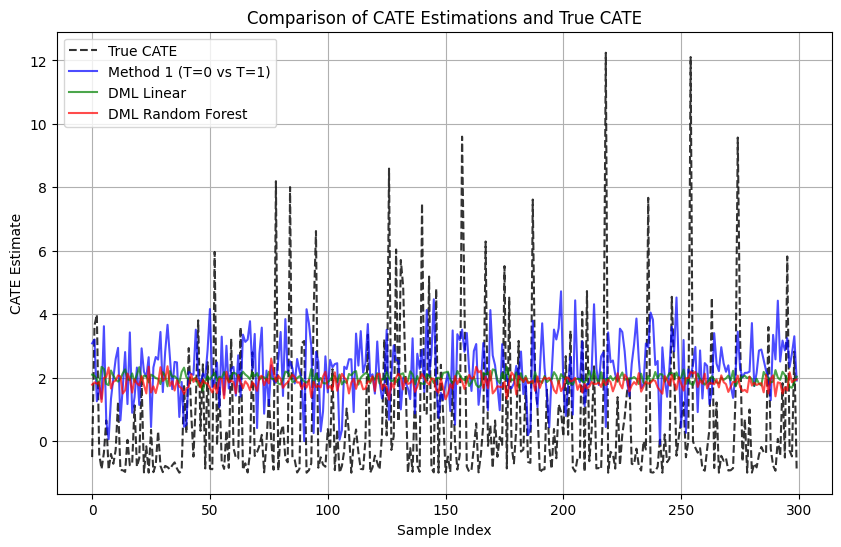

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.dml import LinearDML

# 1. 生成数据
np.random.seed(42)

# 生成样本数据
n = 1000  # 样本数量
X = np.random.randn(n, 3)  # 协变量 X
T = np.random.binomial(1, 0.5, size=n)  # 治疗变量 T（0 或 1）

# 设定非线性 CATE (条件治疗效应)
true_cate = 2 * X[:, 0] ** 2 - 1  # 非线性效应

# 结果变量 Y
Y = 5 + 2 * T + X[:, 0] + X[:, 1] + true_cate + np.random.normal(0, 1, n)

# 划分训练集和测试集
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

# 2. 估计 CATE 方法 1: 基于 T=0 和 T=1 的模型比较

def method_1(X, T, Y, model=LinearRegression()):
    # 先使用模型训练
    model.fit(X[T == 0], Y[T == 0])  # 训练模型：T=0时的样本
    Y0_pred = model.predict(X)  # 预测所有样本的T=0时的Y
    
    model.fit(X[T == 1], Y[T == 1])  # 训练模型：T=1时的样本
    Y1_pred = model.predict(X)  # 预测所有样本的T=1时的Y
    
    return Y1_pred - Y0_pred  # CATE

# 3. 估计 CATE 方法 2: DML Linear
model_dml_linear = LinearDML(model_y=LinearRegression(), model_t=LinearRegression(), cv=3)
model_dml_linear.fit(Y_train, T_train, X=X_train)
cate_dml_linear = model_dml_linear.effect(X_test)

# 4. 估计 CATE 方法 3: DML Random Forest
model_dml_rf = LinearDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor(), cv=3)
model_dml_rf.fit(Y_train, T_train, X=X_train)
cate_dml_rf = model_dml_rf.effect(X_test)

# 5. 估计方法 1 CATE
cate_method_1 = method_1(X_test, T_test, Y_test)

# 6. 绘制图表，比较估计 CATE 和真实 CATE
plt.figure(figsize=(10, 6))
plt.plot(true_cate[:len(cate_method_1)], label="True CATE", color='black', linestyle='--', alpha=0.8)
plt.plot(cate_method_1, label="Method 1 (T=0 vs T=1)", color='blue', alpha=0.7)
plt.plot(cate_dml_linear, label="DML Linear", color='green', alpha=0.7)
plt.plot(cate_dml_rf, label="DML Random Forest", color='red', alpha=0.7)

plt.xlabel("Sample Index")
plt.ylabel("CATE Estimate")
plt.legend()
plt.title("Comparison of CATE Estimations and True CATE")
plt.grid(True)
plt.show()


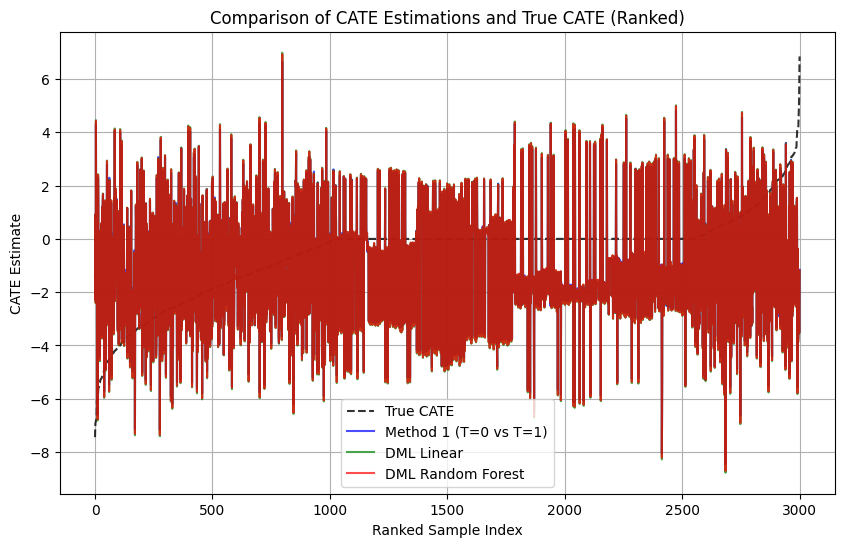

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.dml import LinearDML

# 1. 生成数据
np.random.seed(42)

# 生成样本数据
n = 10000  # 样本数量
X = np.random.randn(n, 3)  # 协变量 X
T = np.random.binomial(1, 0.5, size=n)  # 治疗变量 T（0 或 1）


# 设定非线性 CATE (条件治疗效应)
true_cate = T*(2 * X[:, 0]  - 1)  # 非线性效应

# 结果变量 Y
Y = 5 +  X[:, 0] + X[:, 1] + true_cate + np.random.normal(0, 1, n)

# 划分训练集和测试集
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

# 2. 估计 CATE 方法 1: 基于 T=0 和 T=1 的模型比较

def method_1(X, T, Y, model=LinearRegression()):
    # 先使用模型训练
    model.fit(X[T == 0], Y[T == 0])  # 训练模型：T=0时的样本
    Y0_pred = model.predict(X)  # 预测所有样本的T=0时的Y
    
    model.fit(X[T == 1], Y[T == 1])  # 训练模型：T=1时的样本
    Y1_pred = model.predict(X)  # 预测所有样本的T=1时的Y
    
    return Y1_pred - Y0_pred  # CATE

# 3. 估计 CATE 方法 2: DML Linear
model_dml_linear = LinearDML(model_y=LinearRegression(), model_t=LinearRegression(), cv=3)
model_dml_linear.fit(Y_train, T_train, X=X_train)
cate_dml_linear = model_dml_linear.effect(X_test)

# 4. 估计 CATE 方法 3: DML Random Forest
model_dml_rf = LinearDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor(), cv=3)
model_dml_rf.fit(Y_train, T_train, X=X_train)
cate_dml_rf = model_dml_rf.effect(X_test)

# 5. 估计方法 1 CATE
cate_method_1 = method_1(X_test, T_test, Y_test)

# 6. 将所有 CATE 放入一个 Pandas DataFrame
cate_df = pd.DataFrame({
    "True CATE": true_cate[X_test[:, 0].argsort()],
    "Method 1 (T=0 vs T=1)": cate_method_1[X_test[:, 0].argsort()],
    "DML Linear": cate_dml_linear[X_test[:, 0].argsort()],
    "DML Random Forest": cate_dml_rf[X_test[:, 0].argsort()]
})

# 7. 排序 DataFrame 根据 True CATE 排名
cate_df_sorted = cate_df.sort_values(by="True CATE", ascending=True)

# 8. 绘制图表，比较估计 CATE 和真实 CATE（按排名排序）
plt.figure(figsize=(10, 6))
plt.plot(cate_df_sorted["True CATE"].values, label="True CATE", color='black', linestyle='--', alpha=0.8)
plt.plot(cate_df_sorted["Method 1 (T=0 vs T=1)"].values, label="Method 1 (T=0 vs T=1)", color='blue', alpha=0.7)
plt.plot(cate_df_sorted["DML Linear"].values, label="DML Linear", color='green', alpha=0.7)
plt.plot(cate_df_sorted["DML Random Forest"].values, label="DML Random Forest", color='red', alpha=0.7)

plt.xlabel("Ranked Sample Index")
plt.ylabel("CATE Estimate")
plt.legend()
plt.title("Comparison of CATE Estimations and True CATE (Ranked)")
plt.grid(True)
plt.show()


In [70]:
cate_method_1

array([ 3.07907202e+00,  3.20208475e+00,  1.25229366e+00,  1.76081185e+00,
        1.32973434e+00,  3.62024999e+00,  6.26561590e-01,  5.70786315e-02,
        1.32554375e+00,  1.99160129e+00,  2.58990947e+00,  2.93706474e+00,
        6.51449470e-01,  1.68859002e+00,  2.80497766e+00,  1.16430697e+00,
        3.42465658e+00,  8.90566320e-01,  1.38110348e+00,  2.31686236e+00,
        1.13820027e+00,  2.92304952e+00,  2.18271362e+00,  2.02107690e+00,
        2.64323794e+00,  4.40697931e-01,  2.31952264e+00,  2.64960136e+00,
        2.56708955e+00,  3.43894504e+00,  1.54314613e+00,  2.81306400e+00,
        3.66497092e+00,  2.64669334e+00,  1.63404075e+00,  2.49421151e+00,
        2.47907715e+00,  7.57661738e-01,  1.86291168e+00,  4.50018754e-01,
        5.19427615e-01,  2.17496057e+00,  2.11955212e+00,  2.08765604e+00,
        3.51135146e+00,  2.07044764e+00,  1.80016851e+00,  2.12710478e+00,
        1.99795853e+00,  2.86929671e+00,  4.16189981e+00,  1.69661197e+00,
        1.87203916e+00,  